In [816]:

from fitparse import FitFile
from datetime import datetime
from math import sqrt, pi, cos,sin, atan2, isnan
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
from tqdm import tqdm, trange

from itertools import chain
from xml.dom import minidom
#%matplotlib ipympl
R = 6371000 #earth radius [m]


In [110]:
cicle = FitFile('fit_files/2915321598.fit')#cycle
dive = FitFile('fit_files/2918764166.fit')#dive
swim = FitFile('fit_files/2918975969.fit') #swim
swimgpx='fit_files/schwimmen2018-08-09_16-10-45.gpx'


In [1137]:
def toDegree(s, t="semicircle"): 
    d=[float('nan')]*len(s)
    if t =="semicircle":   
        if(np.any(s==False)):
            s[s == None]=0
        s=np.array(s, dtype=np.uint32)
        d=s*180/2**31
        r[r==0]=np.nan
    elif t == "radian":
        s=np.array(s, dtype=float)
        d=s*180/pi
    return d
def toRadian(s, t="semicircle"): 
    
    r=[float('nan')]*len(s)
    if t =="semicircle":
        if(np.any(s==False)):
            s[s == None]=0
        s=np.array(s, dtype=np.uint32)
        r=s*pi/2**31
        r[r==0]=np.nan
    elif t == "degree":
        s=np.array(s, dtype=float)
        r=s*180/2**31
    return r

def toSemicircle(r, t="radian"):
    r=np.array(r, dtype=float)
    s=[0]*len(r)
    if t =="radian":
        s=(r*2**31/pi)
    elif t == "degree":
        s=(r*2**31/180)
    return(s.astype(np.uint32))
    


def trackDev(lat1, lng1,lat2,lng2, t='semicircle'):
    R = 6371000 #earth radius [m]
    if t != "radian":
        lat1=toRadian(lat1, t)
        lng1=toRadian(lng1, t)
        lat2=toRadian(lat2, t)
        lng2=toRadian(lng2, t)
    else:
        lat1=np.array(lat1)
        lng1=np.array(lng1)
        lat2=np.array(lat2)
        lng2=np.array(lng2)
    delta_lat_m=(lat2-lat1) * R
    delta_lng_m=(lng2-lng1) * np.cos(lat1) * R
    dist=np.sqrt(delta_lat_m**2+delta_lng_m**2)
    return(pd.DataFrame({'delta_lat': delta_lat_m,  'delta_lng': delta_lng_m, 'dist': dist}))

def toDeltaMeter(lat, lng, t='semicircle'):
    R = 6371000 #earth radius [m]
    if t != "radian":
        lat=toRadian(lat, t)
        lng=toRadian(lng, t)
    delta_lat=np.diff(lat)
    delta_lng=np.diff(lng)
    delta_lat_m=delta_lat * R
    delta_lng_m=delta_lng * R * np.cos(np.array(lat[:-1]))
    dist=np.sqrt(delta_lat_m**2+delta_lng_m**2)
    return(pd.DataFrame({'delta_lat': delta_lat_m,  'delta_lng': delta_lng_m, 'dist': dist}))
    


In [729]:
def runningMean(x, N):
    return np.convolve(x, np.ones((N,))/N, 'same')


In [120]:
#READ GPX FILE
def parseGPX(filename):
    gpx=open(filename)
    data={}
    xmldoc = minidom.parse(gpx)
    track = xmldoc.getElementsByTagName('trkpt')
    elevation=xmldoc.getElementsByTagName('ele')
    timestamp=xmldoc.getElementsByTagName('time')
    accuracy=xmldoc.getElementsByTagName('pdop')
    n_track=len(track)
    #PARSING GPX ELEMENT
    data['lng']=[]
    data['lat']=[]
    data['elev']=[]
    data['time']=[]
    data['accuracy']=[]
    for s in range(n_track):
        lng,lat=track[s].attributes['lon'].value,track[s].attributes['lat'].value
        elev=elevation[s].firstChild.nodeValue
        acc=accuracy[s].firstChild.nodeValue
        data['lng'].append(float(lng))
        data['lat'].append(float(lat))
        data['elev'].append(float(elev))
        data['time'].append(datetime.strptime(timestamp[s].firstChild.nodeValue, "%Y-%m-%dT%H:%M:%S.000Z"))
        data['accuracy'].append(float(acc))
    return data

In [1126]:
def parseFit(fitfile, gpxdata=None):
    init_time=5 # time to initialize gps
    data={}
    # Get all data messages that are of type record
    for i, record in enumerate(fitfile.get_messages('record')):
        #print("{}___".format(i))
        # Go through all the data entries in this record
        fields=set([])
        for record_data in record:
            # Print the records name and value (and units if it has any)
            fields.add(record_data.name)
            #if i==0: #print first
            if False: #do not print
                if record_data.units:
                    print (" * {}: {} {}".format(record_data.name, record_data.value, record_data.units))
                else:
                    print (" * {}: {}".format(record_data.name, record_data.value))
            if record_data.name not in data:
                data[record_data.name]=[None] * i
            data[record_data.name].append(record_data.value)
        for missing in set(data.keys()).difference(fields):
            data[missing].append(None)
        
    for n in data.keys():
        if isinstance(data[n][0], tuple):
            data[n]=list(chain.from_iterable(data[n]))
        
        data[n]=np.array(data[n])#, dtype=np.float)
        dty=np.array([type(e) for i,e in enumerate(data[n])])
        if(data[n].dtype == 'O' and sum(dty ==int)>10):
            data[n][dty != int]=0
            data[n]=data[n].astype(int)
        if(data[n].dtype == 'O' and sum(dty ==float)>10):
            data[n][dty != float]=float('nan')
            data[n]=data[n].astype(float)
    mWS=9807 #Pa
    amb_pressure=np.nanmedian(data['pressure'][0:150])
    #amb_pressure=100000
    data['depth']=(amb_pressure-data['pressure'])/mWS*100
    data['depth'][np.isnan(data['depth'])]=-100
    data['depth'][data['depth']>0]=0
    track=toDeltaMeter(data['position_lat'],data['position_long'], "semicircle" )
    idx=np.argmax(np.logical_and(data['position_lat']  != 0 , data['position_long']  != 0))+init_time
    #hope that the others have values at this position as well
    data['lng_rel_meter']=np.nancumsum(track['delta_lng'])
    data['lat_rel_meter']=np.nancumsum(track['delta_lat'])
    print("track offset {},{}".format(data['lat_rel_meter'][idx],data['lng_rel_meter'][idx]))
    offset_base=(data['lng_rel_meter'][idx],data['lat_rel_meter'][idx] )
    data['lng_rel_meter']-=offset_base[0]
    data['lat_rel_meter']-=offset_base[1]
    track=toDeltaMeter(data['gps_lat'],data['gps_lng'], "semicircle" )
    data['gps_lng_rel_meter']=np.nancumsum(track['delta_lng'])
    data['gps_lat_rel_meter']=np.nancumsum(track['delta_lat'])    
    dev=trackDev([data['gps_lat'][idx]],[data['gps_lng'][idx]],[data['position_lat'][idx]],[data['position_long'][idx]] )
    print("dev : "+str(dev.iloc[0]))

    offset=(data['gps_lng_rel_meter'][idx]+dev['delta_lng'][0],
            data['gps_lat_rel_meter'][idx]+dev['delta_lat'][0])
            
    print("gps offset: "+str(offset))
    data['gps_lng_rel_meter']-=offset[0]
    data['gps_lat_rel_meter']-=offset[1]
    
    if gpxdata is not None:
        trueLat=toSemicircle(gpxdata['lat'], "degree")
        trueLng=toSemicircle(gpxdata['lng'], "degree")
        delta=toDeltaMeter(trueLat, trueLng)
        smooth_delta_lng=runningMean(delta['delta_lng'],5)
        smooth_delta_lat=runningMean(delta['delta_lat'],5)
        
        #heading=delta.apply(lambda row: atan2(row['delta_lng'], row['delta_lat']), axis=1)
        heading=[atan2(smooth_delta_lng[i], smooth_delta_lat[i]) for i in range(len(smooth_delta_lng))]
        gpxdata['time']=np.array(gpxdata['time'])
        data['true_lat']=[]
        data['true_lng']=[]
        data['true_heading']=[]
        for i in range(len(data['timestamp'])) :
            dt=[(data['timestamp'][i]-t).total_seconds() for j,t in enumerate(gpxdata['time'])]
            matchedI=np.argmin(np.abs(dt))
            data['true_lat'].append(trueLat[matchedI])
            data['true_lng'].append(trueLng[matchedI])
            data['true_heading'].append(heading[matchedI])
            
        data['true_lat']=np.array(data['true_lat'])
        data['true_lng']=np.array(data['true_lng'])
        
        #print(str(type(data['position_lat']))+"--"+str(type(data['true_lat'])))
        track=toDeltaMeter(data['true_lat'],data['true_lng'], "semicircle" )
        dev=trackDev([data['true_lat'][idx]],[data['true_lng'][idx]],[data['position_lat'][idx]],[data['position_long'][idx]] )
        
        data['true_lng_rel_meter']=np.nancumsum(track['delta_lng'])
        data['true_lat_rel_meter']=np.nancumsum(track['delta_lat'])
        #data['true_lng_rel_meter']-=data['true_lng_rel_meter'][idx]
        #data['true_lat_rel_meter']-=data['true_lat_rel_meter'][idx]
        offset=(data['true_lng_rel_meter'][idx]+dev['delta_lng'][0],
            data['true_lat_rel_meter'][idx]+dev['delta_lat'][0])
        print("true offset: "+str(offset))
        data['true_lng_rel_meter']-=offset[0]
        data['true_lat_rel_meter']-=offset[1]
    
        error= trackDev(data['position_lat'], data['position_long'], data['true_lat'], data['true_lng'], "semicircle")
        data['error_abs']=np.array(error['dist'])
        data['error_lat']=np.array(error['delta_lat'])
        data['error_lng']=np.array(error['delta_lng'])
        data['error_head']=[error['delta_lat'][i]*sin(data['true_heading'][i])+error['delta_lng'][i]*cos(data['true_heading'][i]) for i in range(len(data['true_heading']))]
        data['error_side']=[error['delta_lat'][i]*cos(data['true_heading'][i])-error['delta_lng'][i]*sin(data['true_heading'][i]) for i in range(len(data['true_heading']))]
            
        
        
        
        
        
    return data

In [971]:
def plotData(data, start, end):
    t = np.arange(0., len(data['gps_time']), 1/15)
    lim=(np.argmax(t > start)-1,np.argmax(t>end))
    mask=slice(lim[0], lim[1])
        
    idx=data['gps_time']
    idx[np.isnan(idx)]=0
    idx=(np.arange(0, len(data['gps_time']))*15+idx).astype(int)
    gps_time=t[idx]
    lim2=(np.argmax(gps_time > start)-1,np.argmax(gps_time>end))
    mask2=slice(lim2[0], lim2[1])
    
    #print(str(gps_time))
    col=np.array(["green", "red", "gray"])
    depth=data['depth']
    
    gps_underwater=(depth[idx.astype(int)]< - 5).astype(int)
    gps_underwater[np.isnan(data['position_lat'])]=2
    cols=col[gps_underwater]
    
    ax = plt.subplot(5, 1, 1)
    ax.plot(t[mask], data['accel_X'][mask], 'r--', t[mask], data['accel_Y'][mask], 'b--', t[mask],data['accel_Z'][mask], 'g--')
    #plt.xlim(lim[0],lim[1])
    drange=[np.nanmin(np.array([data['accel_X'], data['accel_Y'], data['accel_Z']])), 
           np.nanmax(np.array([data['accel_X'], data['accel_Y'], data['accel_Z']]))]
    ax.vlines(x=gps_time[mask2], ymin=drange[0], ymax=drange[1], color=cols[mask2], linestyle='--')
    #ax.grid(color='grey', linestyle='-', linewidth=1)


    ax = plt.subplot(5, 1, 2)
    ax.plot(t[mask], data['mag_X'][mask], 'r--', t[mask], data['mag_Y'][mask], 'b--', t[mask],data['mag_Z'][mask], 'g--')
    #plt.xlim(lim[0],lim[1])
    drange=[np.nanmin(np.array([data['mag_X'], data['mag_Y'], data['mag_Z']])), 
           np.nanmax(np.array([data['mag_X'], data['mag_Y'], data['mag_Z']]))]
    ax.vlines(x=gps_time[mask2], ymin=drange[0], ymax=drange[1], color=cols[mask2], linestyle='--')
    #ax.grid(color='grey', linestyle='-', linewidth=1)


    ax = plt.subplot(5, 1, 3)
    ax.plot(t[mask],depth[mask] , '--' )
    #plt.xlim(lim[0],lim[1])
    drange=[np.nanmin(depth), 
           np.nanmax(depth)]
    ax.vlines(x=gps_time[mask2], ymin=drange[0], ymax=drange[1], color=cols[mask2], linestyle='--')
    #ax.grid(color='grey', linestyle='-', linewidth=1)

    if 'true_lng' in data.keys():
        #dev=trackDev(data['position_lat'], data['position_long'], data['true_lat'], data['true_lng'])
        ax = plt.subplot(5, 1, 4)
        
        ax.plot(gps_time[mask2],data['error_abs'][mask2] , '--' )
        ax.plot(gps_time[mask2],data['error_lat'][mask2] , 'g--' )
        ax.plot(gps_time[mask2],data['error_lng'][mask2] , 'r--' )
        plt.hlines([0], start,end)
        #plt.xlim(lim[0],lim[1])
        
        ax = plt.subplot(5, 1, 5)
        
        ax.plot(gps_time[mask2],data['error_head'][mask2] , 'g--' )
        ax.plot(gps_time[mask2],data['error_side'][mask2] , 'r--' )
        plt.hlines([0], start, end)

        #plt.xlim(lim[0],lim[1])
        ax.relim()
        ax.autoscale(enable=True, axis='y')
    ax.figure.set_size_inches(20,20)
    plt.show()


In [951]:
def plotPos(data,gpx=None, start=0, end=10, garmin=True, app=True, phone=True , drawPoints=False, colBy="underwater", ax = None):

    t = np.arange(0., len(data['gps_time']), 1/15)
    idx=data['gps_time']
    idx[np.isnan(idx)]=0
    idx=(np.arange(0, len(data['gps_time']))*15+idx).astype(int)    
    gps_time=t[idx]
    start, end=(np.argmax(gps_time > start)-1,np.argmax(gps_time>end))
    print("({},{})".format(start, end))
    if end == 0:
        end=len(t)
    
    #print(str(gps_time))
    cols='b'
    if(colBy =="underwater"):
        depth=data['depth']
        gps_underwater=(depth[idx.astype(int)]< - 5).astype(int)
        gps_underwater[np.isnan(data['position_lat'])]=2
        cols=gps_underwater
        cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "red"], N=2)
    elif colBy =="error" and 'error_abs' in data.keys():
        cols=data['error_abs']
        cols[np.isnan(cols)]=np.nan
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#01ff07","green","orange","red", "purple"], N=100)
    else:
        cols=np.array([1])
        cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "black"], N=1)
    minc=np.nanmin(cols)
    maxc=np.nanmax(cols)    
    if ax is None:
        ax = plt.gca()
    if garmin:
        #track=toDeltaMeter(data['position_lat'],data['position_long'], "semicircle" )
        ax.plot(  data['lng_rel_meter'][start:end], data['lat_rel_meter'][start:end],c='tab:brown', linestyle='--')
        if drawPoints:
            ax.scatter(  data['lng_rel_meter'][start:end], data['lat_rel_meter'][start:end], s=10,c=list(cols)[start:end], cmap=cmap, vmin=minc, vmax=maxc)
    if app:
    
        
        #track=toDeltaMeter(data['gps_lat'],data['gps_lng'], "semicircle" )
        ax.plot(  data['gps_lng_rel_meter'][start:end], data['gps_lat_rel_meter'][start:end],c='tab:orange', linestyle='--')
        if drawPoints:
            ax.scatter(   data['gps_lng_rel_meter'][start:end], data['gps_lat_rel_meter'][start:end], s=10,c=list(cols)[start:end], cmap=cmap, vmin=minc, vmax=maxc)
    if phone:
        if 'true_lat' in data.keys():
            #track=toDeltaMeter(data['true_lat'],data['true_lng'], "semicircle" )
            ax.plot(   data['true_lng_rel_meter'][start:end], data['true_lat_rel_meter'][start:end],c='tab:blue', linestyle='--')
        
    

        
    ax.axis('equal')
    
    

# Observations

In [1138]:
#load data
print("dive")
diveData=parseFit(dive)
print("\n-------\nswim")
swimGpxData=parseGPX(swimgpx)
swimData=parseFit(swim, swimGpxData)


dive
track offset 5.303222865978396,7.525563195624732
dev : delta_lat    1.267554
delta_lng   -0.806513
dist         1.502384
Name: 0, dtype: float64
gps offset: (7.020072861210456, 6.030202450170941)

-------
swim
track offset -2.9358790907972887,1.9310836475876911
dev : delta_lat    0.083882
delta_lng    0.505490
dist         0.512403
Name: 0, dtype: float64
gps offset: (13.55169266795677, 4.557602779808434)
true offset: (-0.630443085788815, 0.8108618441519111)


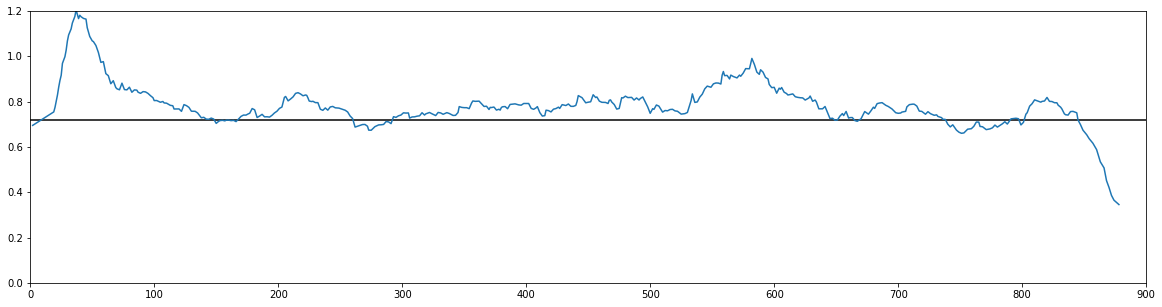

In [833]:
# speed
lng1=swimData['position_long']
lat1=swimData['position_lat']
lng2=swimData['gps_lng']
lat2=swimData['gps_lat']
lng3=swimData['true_lng']
lat3=swimData['true_lat']
dif_garmin=trackDev(lat1, lng1, lat3, lng3)
#1 and 2 are between 17 cm and 1 meter off (strange)
track=toDeltaMeter(lat3, lng3)
moved=list(np.logical_or(np.diff(lat3)!=0 , np.diff(lng3)!=0))
time=np.arange(len(moved))[moved]
dt=[1]+list(np.diff(time))
dist=list(track['dist'][moved])
speed=[dist[i]/dt[i] for i in range(len(dist))]
plt.hlines([np.nanmedian(speed)], lim[0],lim[1])
plt.plot(time, runningMean(speed,30))
lim=(0,900)
plt.xlim(lim[0],lim[1])
plt.ylim(0,1.2)
fig = plt.gcf() 
fig.set_size_inches(20,5)

In [989]:
trackDev(swimData['position_lat'], swimData['position_long'], swimData['gps_lat'], swimData['gps_lng']).head(10)

,delta_lat,delta_lng,dist
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,-7.884932,-14.744637,16.720541
6,-0.167765,-0.046601,0.174117
7,-0.167765,-0.046601,0.174117
8,-0.167765,-0.046601,0.174117
9,-0.167765,-0.046601,0.174117


In [990]:
trackDev(swimData['position_lat'], swimData['position_long'], swimData['true_lat'], swimData['true_lng']).head(10)

,delta_lat,delta_lng,dist
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,-3.383251,4.632165,5.736143
6,-1.789488,-1.537841,2.359497
7,-1.043868,-1.099790,1.516311
8,-0.568535,-1.286195,1.406246
9,-0.223686,-1.295515,1.314684


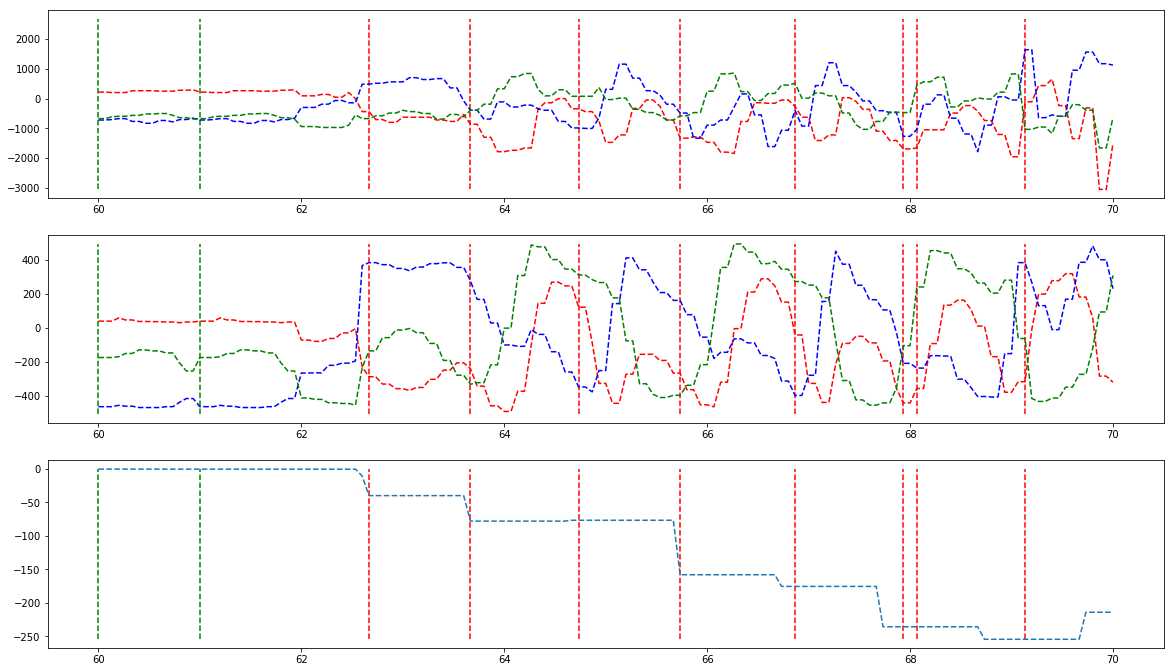

In [1139]:
plotData(diveData,start=60,end=70)

(0,40)


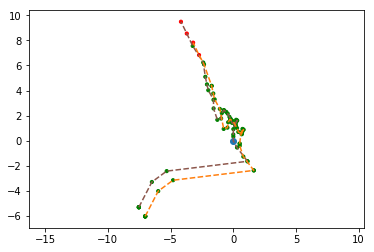

In [1141]:
plotPos(diveData, start=0, end=40, drawPoints=True)
plt.scatter(0,0)


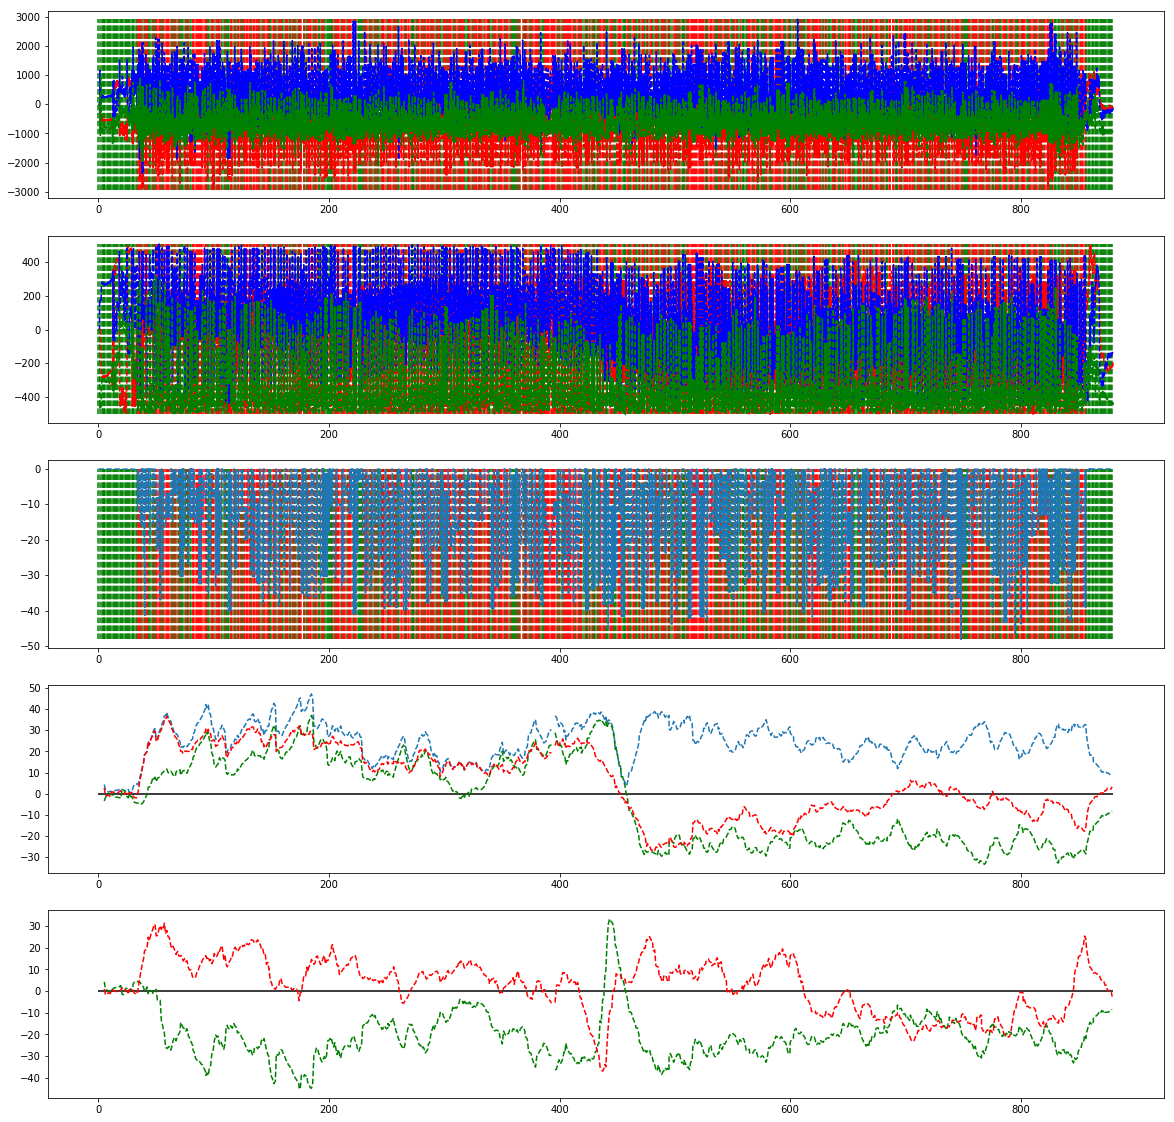

In [1149]:
plotData(swimData,start=0,end=880)

(40,51)
(40,51)


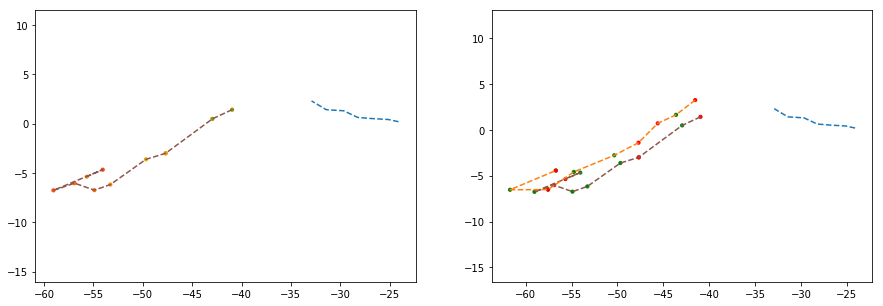

In [1142]:
f, (ax1, ax2) = plt.subplots(1, 2,  figsize=(15,5))#sharey=True,
lim=(40,51)
plotPos(swimData,start=lim[0],end=lim[1], drawPoints=True,app=False, colBy="error", ax=ax1)
plotPos(swimData,start=lim[0],end=lim[1], drawPoints=True,app=True, colBy="underwater", ax=ax2)


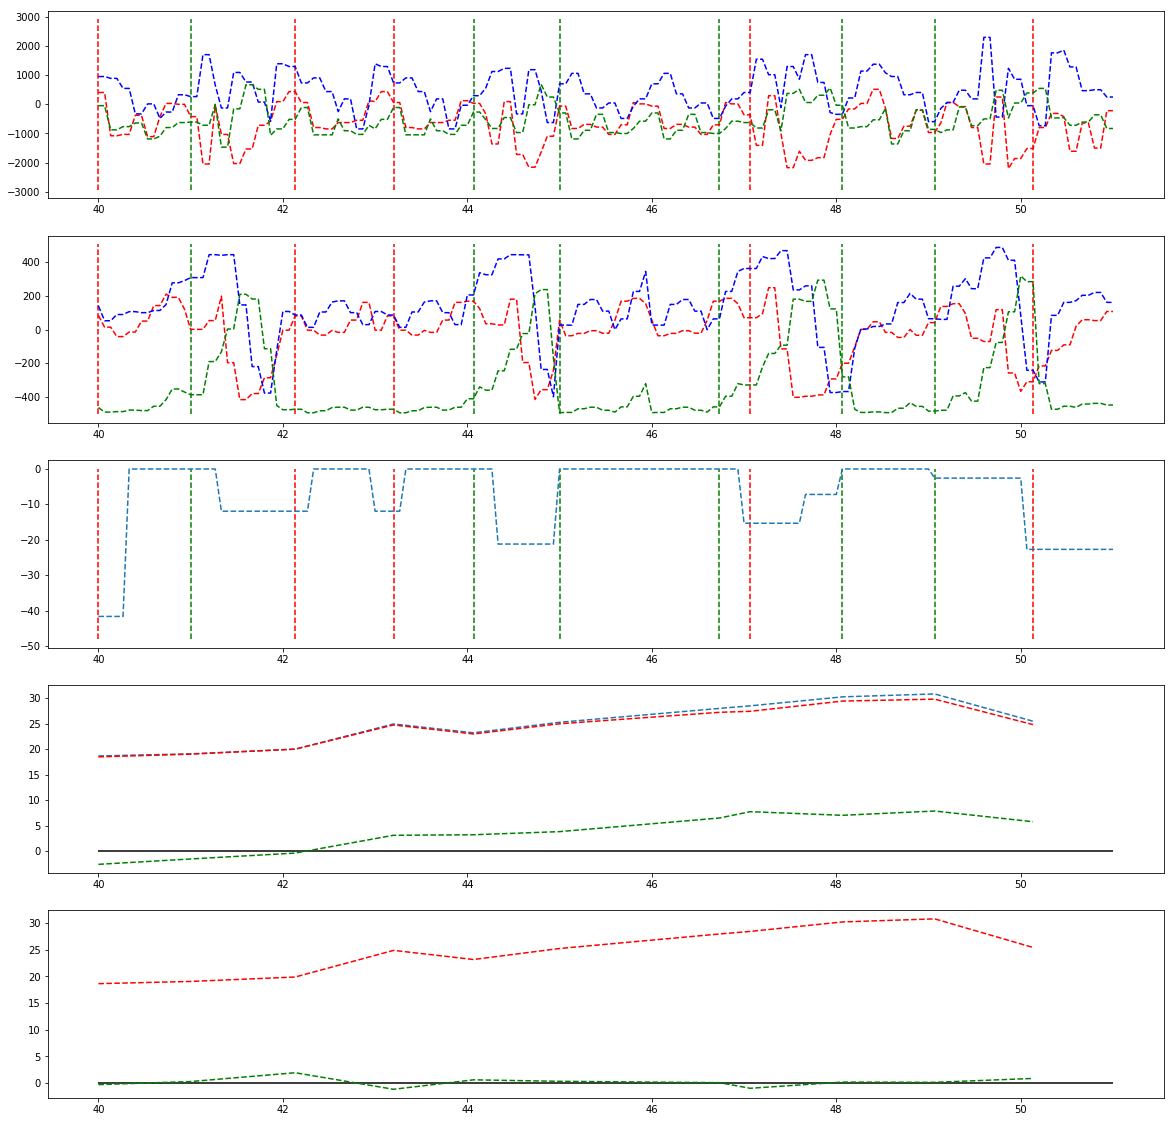

In [1143]:
plotData(swimData,start=lim[0],end=lim[1])

(4,41)


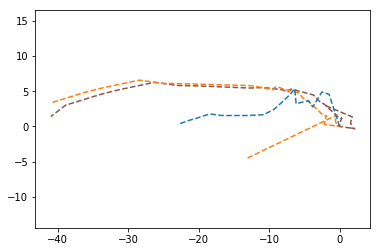

In [1042]:
plotPos(swimData,start=5,end=40)

In [138]:

idx=(np.arange(0, len(swimData['gps_time']))*15+swimData['gps_time']).astype(int)

In [126]:
depth[idx.astype(int)]< -1

IndexError: index -9223372036854775808 is out of bounds for axis 1 with size 10485

In [127]:
["red", "blue"][(depth[idx.astype(int)]< -1).astype(int)]

IndexError: index -9223372036854775808 is out of bounds for axis 1 with size 10485

In [128]:
(depth[idx.astype(int)]< -1).astype(int)

IndexError: index -9223372036854775808 is out of bounds for axis 1 with size 10485